In [1]:
import pandas as pd
import numpy as np
import json
import yaml
from scipy import stats
import seaborn as sn
import pickle

from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import rankdata

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [59]:
metrics =  [
    'Model Parameter Randomisation',
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity'    
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    # 'baseline_mean', not used anymore as there's some probs with quantus implementation
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]
                
transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': lambda x: x,
    'Faithfulness Correlation': lambda x: x, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: -parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

aggregate = {
    'Monotonicity Nguyen': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Local Lipschitz Estimate': np.mean,
    'Faithfulness Estimate': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Faithfulness Correlation': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Avg-Sensitivity': np.mean,
    'Random Logit': np.mean,
    'Max-Sensitivity': np.mean,
    'Sparseness': np.mean, 
    'EffectiveComplexity': np.mean,
    'Monotonicity Arya': np.mean,
    'Complexity': np.mean,
    'Pixel-Flipping': np.mean,
    'Selectivity': np.mean,
    'Model Parameter Randomisation': np.mean
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}

In [5]:
CSV_DIR = "csv_merged"

for metr in metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            scores = []
            for meth in methods:
                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
                df = pd.read_csv(csv_name, header = None)
                data = transform[metr](df).values.flatten()
                scores.append(-aggregate[metr](data))
            dico_ranks[metr_with_baseline] = rankdata(scores)
#    elif metr == 'Model Parameter Randomisation':
#        for baseline in ['bottom_up','top_down']:
#            metr_with_baseline = f'{metr} with {baseline}'
#            print(f"-- Metric: {metr_with_baseline}")
#            scores = []
#            for meth in methods:
#                csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
#                df = pd.read_csv(csv_name, header = None)
#                data = transform[metr](df).values.flatten()
#                scores.append(-aggregate[metr](data))
#            dico_ranks[metr_with_baseline] = rankdata(scores)
    else:
        print(f"-- Metric: {metr}")
        scores = []
        for meth in methods:
            csv_name = f"{CSV_DIR}/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data = transform[metr](df).values.flatten()
            scores.append(-aggregate[metr](data))                
        dico_ranks[metr] = rankdata(scores)

with open('rankings_by_avg_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

-- Metric: Model Parameter Randomisation
-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Arya with baseline_black
-- Metric: Monotonicity Arya with baseline_random
-- Metric: Monotonicity Arya with baseline_u

In [60]:
with open('rankings_by_avg_aggreg.pickle', 'rb') as file:
    dico_ranks = pickle.load(file)

In [61]:
df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

In [62]:
df_ranks

,Model Parameter Randomisation,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,Faithfulness Estimate with baseline_white,...,Monotonicity Arya with baseline_white,Complexity,Pixel-Flipping with baseline_black,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white
integratedgrad,2.0,7.0,7.0,7.0,7.0,7.0,11.0,11.0,11.0,11.0,...,10.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0
smoothgrad,7.0,1.0,1.0,1.0,1.0,10.0,5.0,5.0,5.0,5.0,...,8.0,8.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0
guidedbackprop,9.0,6.0,6.0,6.0,6.0,3.0,8.0,8.0,8.0,8.0,...,11.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0
rise,1.0,8.0,8.0,8.0,8.0,8.0,4.0,4.0,4.0,4.0,...,3.0,10.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0
gradcam,4.0,2.0,2.0,2.0,2.0,4.0,1.0,1.0,1.0,1.0,...,4.0,4.0,10.0,10.0,10.0,10.0,11.0,11.0,11.0,11.0
scorecam,8.0,4.0,4.0,4.0,4.0,5.0,3.0,3.0,3.0,3.0,...,5.0,6.0,11.0,11.0,11.0,11.0,10.0,10.0,10.0,10.0
layercam,5.0,3.0,3.0,3.0,3.0,9.0,2.0,2.0,2.0,2.0,...,6.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
random,3.0,11.0,11.0,11.0,11.0,11.0,9.0,9.0,9.0,9.0,...,9.0,7.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0
sobel,10.0,10.0,10.0,10.0,10.0,1.0,10.0,10.0,10.0,10.0,...,2.0,3.0,4.0,4.0,4.0,4.0,6.0,6.0,6.0,6.0
gaussian,11.0,9.0,9.0,9.0,9.0,2.0,6.0,6.0,6.0,6.0,...,1.0,11.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


In [63]:
def compute_kendall_w(dico_ranks, metrics):
    rankings = [rankdata(dico_ranks[metric]) for metric in metrics]
        
    data = []
    for i in range(len(rankings[0])):
        data.append([rankings[j][i] for j in range(len(rankings))])   
    
    # source of the implementation : https://github.com/ugolbck/kendall-w/blob/master/kendall_w/kendall_w.py
    m = len(data[0])
    n = len(data)
    sums = [sum(x) for x in data]
    Rbar = sum(sums) / n
    S = sum([(sums[x] - Rbar) ** 2 for x in range(n)])
    W = (12 * S) / (m ** 2 * (n ** 3 - n))

    return W

In [64]:
def compute_kendall_tau(dico_ranks, metrics):
    tau_values = []
    p_values = []

    for metric_a in metrics:
        current_tau_values = []
        current_p_values = []
        for metric_b in metrics:
            tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
            current_tau_values.append(tau)
            current_p_values.append(p_value)
        tau_values.append(current_tau_values)
        p_values.append(current_p_values)
        
    return tau_values, p_values

In [124]:
def plot_corr_matrix_figure(dico_ranks, metrics, y_labels, x_labels, filename, fig_size, rotate_x=True, rotate_y=True, subgroups=None):
    tau_values, p_values = compute_kendall_tau(dico_ranks, metrics)
    
    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')

    sn.set(rc={'figure.figsize': fig_size})

    p_values_flattened = [p_value for i, sublist in enumerate(p_values) for p_value in sublist[:i]]
    reject, _, _, _ = multipletests(p_values_flattened, alpha=0.05, method='holm')
    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = reject[current_post]
            mask[j][i] = reject[current_post]
            current_post += 1

    sn.heatmap(tau_values,
               annot=True,
               vmin=-1,
               vmax=1,
               cbar=False,
               xticklabels=x_labels,
               yticklabels=y_labels,
               mask=mask,
               cmap='coolwarm')

    mask = np.ones((len(metrics),len(metrics)), dtype=bool)
    current_post = 0
    for i in range(len(metrics)):
        for j in range(i):
            mask[i][j] = not reject[current_post]
            mask[j][i] = not reject[current_post]
            current_post += 1
        mask[i][i] = False

    ax = sn.heatmap(tau_values,
                    annot=True,
                    annot_kws={"style": "italic", "weight": "bold"},
                    vmin=-1,
                    vmax=1,
                    cbar=False,
                    xticklabels=x_labels,
                    yticklabels=y_labels,
                    mask=mask,
                    cmap='coolwarm')

    if rotate_x:
        plt.xticks(rotation=0)
    if rotate_y:
        plt.yticks(rotation=0)
    
    start_i = 0
    if subgroups:
        for subgroup_size in subgroups:
            ax.add_patch(Rectangle((start_i, start_i), subgroup_size, subgroup_size, fill=False, edgecolor='black', lw=4, clip_on=False))
            start_i += subgroup_size
    
    plt.savefig(f'./results/{filename}.eps', bbox_inches='tight', format='eps')
    plt.show()
    plt.close()
    
    print('RESULTS')
    print(f"Kendall's W: {compute_kendall_w(dico_ranks, metrics)}")
    print("Kendall's Tau:")
    for i, metric_a in enumerate(metrics):
        for j, metric_b in enumerate(metrics):
            if i < j:
                print(f'{metric_a} / {metric_b} : {tau_values[i][j]} ({p_values[i][j]})')

In [125]:
def plot_same_baseline_diff_metrics_figure(dico_ranks, baseline):   
    selected_metrics = sorted([metric for metric in dico_ranks.keys() if baseline in metric])
    labels = ['Faithfulness Correlation (FC)','Faithfulness Estimate (FE)','Monotonicity Arya (MA)','Monotonicity Nguyen (MN)','Pixel-Flipping (PF)','Selectivity (Se)']
    short_labels = ['FC','FE', 'MA','MN','PF','Se']
    filename = f'final_corr_matrix_avg_aggreg_holm_corr_faithfulness_{baseline}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(5,3))

In [126]:
def plot_same_metric_diff_baselines_figure(dico_ranks, metric):   
    selected_metrics = sorted([metric_n for metric_n in dico_ranks.keys() if metric in metric_n])
    labels = ['Black (B)', 'Random (R)', 'Uniform (U)', 'White (W)']
    short_labels = ['B','R', 'U','W']
    filename = f'final_corr_matrix_avg_aggreg_holm_corr_faithfulness_{metric}'
    plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(3,2))

# Figures and results for article

## Faithfulness: same baseline and different metrics

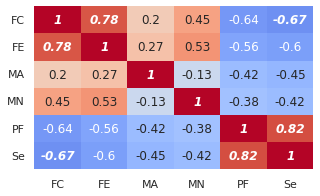

RESULTS
Kendall's W: 0.06565656565656566
Kendall's Tau:
Faithfulness Correlation with baseline_black / Faithfulness Estimate with baseline_black : 0.7818181818181819 (0.0003334435626102293)
Faithfulness Correlation with baseline_black / Monotonicity Arya with baseline_black : 0.2 (0.4453821448613115)
Faithfulness Correlation with baseline_black / Monotonicity Nguyen with baseline_black : 0.45454545454545453 (0.06017015392015392)
Faithfulness Correlation with baseline_black / Pixel-Flipping with baseline_black : -0.6363636363636364 (0.005707170915504249)
Faithfulness Correlation with baseline_black / Selectivity with baseline_black : -0.6727272727272727 (0.0031063111271444604)
Faithfulness Estimate with baseline_black / Monotonicity Arya with baseline_black : 0.2727272727272727 (0.2829668209876543)
Faithfulness Estimate with baseline_black / Monotonicity Nguyen with baseline_black : 0.5272727272727272 (0.02638447971781305)
Faithfulness Estimate with baseline_black / Pixel-Flipping with 

In [127]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_black')

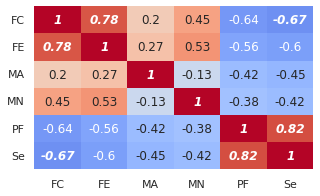

RESULTS
Kendall's W: 0.06565656565656566
Kendall's Tau:
Faithfulness Correlation with baseline_white / Faithfulness Estimate with baseline_white : 0.7818181818181819 (0.0003334435626102293)
Faithfulness Correlation with baseline_white / Monotonicity Arya with baseline_white : 0.2 (0.4453821448613115)
Faithfulness Correlation with baseline_white / Monotonicity Nguyen with baseline_white : 0.45454545454545453 (0.06017015392015392)
Faithfulness Correlation with baseline_white / Pixel-Flipping with baseline_white : -0.6363636363636364 (0.005707170915504249)
Faithfulness Correlation with baseline_white / Selectivity with baseline_white : -0.6727272727272727 (0.0031063111271444604)
Faithfulness Estimate with baseline_white / Monotonicity Arya with baseline_white : 0.2727272727272727 (0.2829668209876543)
Faithfulness Estimate with baseline_white / Monotonicity Nguyen with baseline_white : 0.5272727272727272 (0.02638447971781305)
Faithfulness Estimate with baseline_white / Pixel-Flipping with 

In [128]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_white')

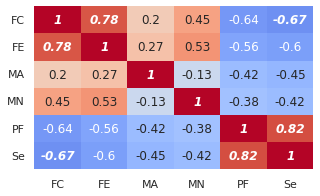

RESULTS
Kendall's W: 0.06565656565656566
Kendall's Tau:
Faithfulness Correlation with baseline_random / Faithfulness Estimate with baseline_random : 0.7818181818181819 (0.0003334435626102293)
Faithfulness Correlation with baseline_random / Monotonicity Arya with baseline_random : 0.2 (0.4453821448613115)
Faithfulness Correlation with baseline_random / Monotonicity Nguyen with baseline_random : 0.45454545454545453 (0.06017015392015392)
Faithfulness Correlation with baseline_random / Pixel-Flipping with baseline_random : -0.6363636363636364 (0.005707170915504249)
Faithfulness Correlation with baseline_random / Selectivity with baseline_random : -0.6727272727272727 (0.0031063111271444604)
Faithfulness Estimate with baseline_random / Monotonicity Arya with baseline_random : 0.2727272727272727 (0.2829668209876543)
Faithfulness Estimate with baseline_random / Monotonicity Nguyen with baseline_random : 0.5272727272727272 (0.02638447971781305)
Faithfulness Estimate with baseline_random / Pixel

In [129]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_random')

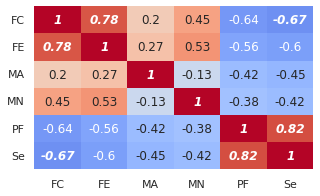

RESULTS
Kendall's W: 0.06565656565656566
Kendall's Tau:
Faithfulness Correlation with baseline_uniform / Faithfulness Estimate with baseline_uniform : 0.7818181818181819 (0.0003334435626102293)
Faithfulness Correlation with baseline_uniform / Monotonicity Arya with baseline_uniform : 0.2 (0.4453821448613115)
Faithfulness Correlation with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.45454545454545453 (0.06017015392015392)
Faithfulness Correlation with baseline_uniform / Pixel-Flipping with baseline_uniform : -0.6363636363636364 (0.005707170915504249)
Faithfulness Correlation with baseline_uniform / Selectivity with baseline_uniform : -0.6727272727272727 (0.0031063111271444604)
Faithfulness Estimate with baseline_uniform / Monotonicity Arya with baseline_uniform : 0.2727272727272727 (0.2829668209876543)
Faithfulness Estimate with baseline_uniform / Monotonicity Nguyen with baseline_uniform : 0.5272727272727272 (0.02638447971781305)
Faithfulness Estimate with baseline_

In [130]:
plot_same_baseline_diff_metrics_figure(dico_ranks, 'baseline_uniform')

## Faithfulness: same metric and different baselines

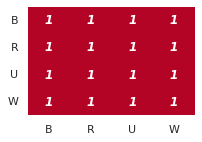

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_random : 1.0 (5.010421677088344e-08)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_uniform : 1.0 (5.010421677088344e-08)
Faithfulness Correlation with baseline_black / Faithfulness Correlation with baseline_white : 1.0 (5.010421677088344e-08)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_uniform : 1.0 (5.010421677088344e-08)
Faithfulness Correlation with baseline_random / Faithfulness Correlation with baseline_white : 1.0 (5.010421677088344e-08)
Faithfulness Correlation with baseline_uniform / Faithfulness Correlation with baseline_white : 1.0 (5.010421677088344e-08)


In [131]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Faithfulness Correlation')

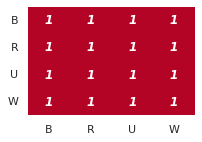

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_random : 1.0 (5.010421677088344e-08)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_uniform : 1.0 (5.010421677088344e-08)
Faithfulness Estimate with baseline_black / Faithfulness Estimate with baseline_white : 1.0 (5.010421677088344e-08)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_uniform : 1.0 (5.010421677088344e-08)
Faithfulness Estimate with baseline_random / Faithfulness Estimate with baseline_white : 1.0 (5.010421677088344e-08)
Faithfulness Estimate with baseline_uniform / Faithfulness Estimate with baseline_white : 1.0 (5.010421677088344e-08)


In [132]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Faithfulness Estimate')

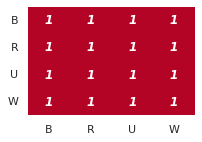

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_random : 1.0 (5.010421677088344e-08)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_uniform : 1.0 (5.010421677088344e-08)
Monotonicity Arya with baseline_black / Monotonicity Arya with baseline_white : 1.0 (5.010421677088344e-08)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_uniform : 1.0 (5.010421677088344e-08)
Monotonicity Arya with baseline_random / Monotonicity Arya with baseline_white : 1.0 (5.010421677088344e-08)
Monotonicity Arya with baseline_uniform / Monotonicity Arya with baseline_white : 1.0 (5.010421677088344e-08)


In [133]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Monotonicity Arya')

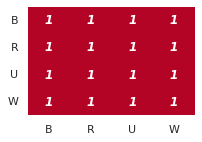

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_random : 1.0 (5.010421677088344e-08)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_uniform : 1.0 (5.010421677088344e-08)
Monotonicity Nguyen with baseline_black / Monotonicity Nguyen with baseline_white : 1.0 (5.010421677088344e-08)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_uniform : 1.0 (5.010421677088344e-08)
Monotonicity Nguyen with baseline_random / Monotonicity Nguyen with baseline_white : 1.0 (5.010421677088344e-08)
Monotonicity Nguyen with baseline_uniform / Monotonicity Nguyen with baseline_white : 1.0 (5.010421677088344e-08)


In [134]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Monotonicity Nguyen')

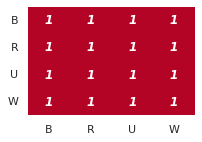

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_random : 1.0 (5.010421677088344e-08)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_uniform : 1.0 (5.010421677088344e-08)
Pixel-Flipping with baseline_black / Pixel-Flipping with baseline_white : 1.0 (5.010421677088344e-08)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_uniform : 1.0 (5.010421677088344e-08)
Pixel-Flipping with baseline_random / Pixel-Flipping with baseline_white : 1.0 (5.010421677088344e-08)
Pixel-Flipping with baseline_uniform / Pixel-Flipping with baseline_white : 1.0 (5.010421677088344e-08)


In [135]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Pixel-Flipping')

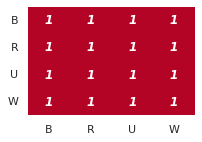

RESULTS
Kendall's W: 1.0
Kendall's Tau:
Selectivity with baseline_black / Selectivity with baseline_random : 1.0 (5.010421677088344e-08)
Selectivity with baseline_black / Selectivity with baseline_uniform : 1.0 (5.010421677088344e-08)
Selectivity with baseline_black / Selectivity with baseline_white : 1.0 (5.010421677088344e-08)
Selectivity with baseline_random / Selectivity with baseline_uniform : 1.0 (5.010421677088344e-08)
Selectivity with baseline_random / Selectivity with baseline_white : 1.0 (5.010421677088344e-08)
Selectivity with baseline_uniform / Selectivity with baseline_white : 1.0 (5.010421677088344e-08)


In [136]:
plot_same_metric_diff_baselines_figure(dico_ranks, 'Selectivity')

## Complexity

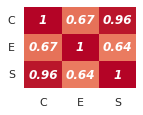

RESULTS
Kendall's W: 0.9151515151515152
Kendall's Tau:
Complexity / EffectiveComplexity : 0.6731618328060892 (0.0045931232121266714)
Complexity / Sparseness : 0.9636363636363636 (5.511463844797178e-07)
EffectiveComplexity / Sparseness : 0.6357639532057509 (0.007432770429930756)


In [137]:
selected_metrics = ['Complexity','EffectiveComplexity','Sparseness']
labels = ['Complexity (C)', 'Effective Complexity (E)', 'Sparseness (S)']
short_labels = ['C','E', 'S']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_complexity'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## Randomization

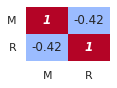

RESULTS
Kendall's W: 0.23636363636363636
Kendall's Tau:
Model Parameter Randomisation / Random Logit : -0.41818181818181815 (0.08656124739458072)


In [138]:
selected_metrics = ['Model Parameter Randomisation', 'Random Logit']
labels = ['Model Parameter Randomisation (M)', 'Random Logit (R)']
short_labels = ['M','R']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_randomization'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(1.5,1))

## Robustness

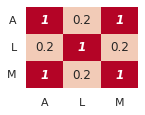

RESULTS
Kendall's W: 0.6606060606060606
Kendall's Tau:
Avg-Sensitivity / Local Lipschitz Estimate : 0.2 (0.4453821448613115)
Avg-Sensitivity / Max-Sensitivity : 1.0 (5.010421677088344e-08)
Local Lipschitz Estimate / Max-Sensitivity : 0.2 (0.4453821448613115)


In [139]:
selected_metrics = ['Avg-Sensitivity','Local Lipschitz Estimate', 'Max-Sensitivity']
labels = ['Avg-Sensitivity (A)', 'Local Lipschitz Estimate (L)', 'Max-Sensitivity (M)']
short_labels = ['A','L', 'M']
filename = 'final_corr_matrix_avg_aggreg_holm_corr_robustness'
plot_corr_matrix_figure(dico_ranks, selected_metrics, short_labels, short_labels, filename, fig_size=(2,1.5))

## All metrics with default baselines (i.e. black)

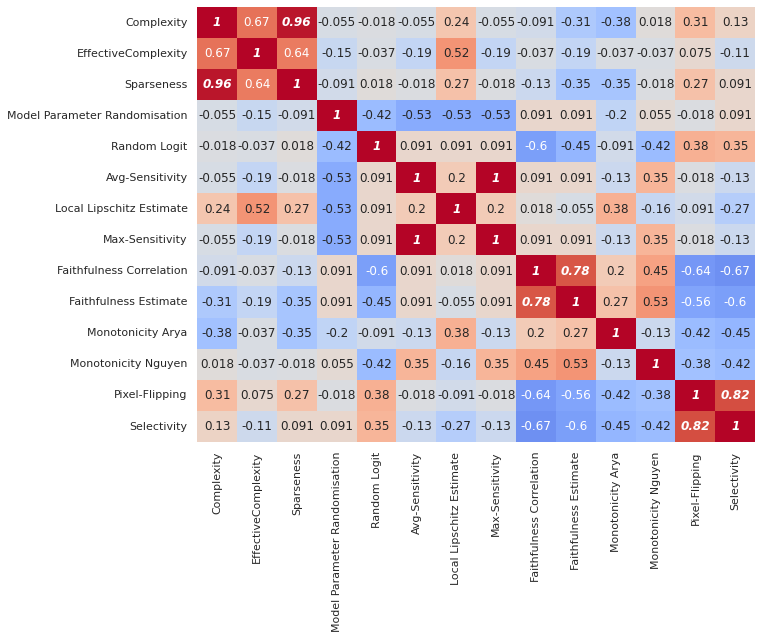

RESULTS
Kendall's W: 0.05398886827458256
Kendall's Tau:
Complexity / EffectiveComplexity : 0.6731618328060892 (0.0045931232121266714)
Complexity / Sparseness : 0.9636363636363636 (5.511463844797178e-07)
Complexity / Model Parameter Randomisation : -0.05454545454545454 (0.8792698312489979)
Complexity / Random Logit : -0.018181818181818184 (1.0)
Complexity / Avg-Sensitivity : -0.05454545454545454 (0.8792698312489979)
Complexity / Local Lipschitz Estimate : 0.23636363636363636 (0.3587114698573032)
Complexity / Max-Sensitivity : -0.05454545454545454 (0.8792698312489979)
Complexity / Faithfulness Correlation with baseline_black : -0.0909090909090909 (0.7611503928170594)
Complexity / Faithfulness Estimate with baseline_black : -0.3090909090909091 (0.21834651074234407)
Complexity / Monotonicity Arya with baseline_black : -0.38181818181818183 (0.12097096961680295)
Complexity / Monotonicity Nguyen with baseline_black : 0.018181818181818184 (1.0)
Complexity / Pixel-Flipping with baseline_black :

In [140]:
selected_metrics =  [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation with baseline_black',
    'Faithfulness Estimate with baseline_black',
    'Monotonicity Arya with baseline_black',
    'Monotonicity Nguyen with baseline_black',
    'Pixel-Flipping with baseline_black',
    'Selectivity with baseline_black'    
]

labels = [
    'Complexity',
    'EffectiveComplexity',
    'Sparseness',
    'Model Parameter Randomisation',
    'Random Logit',   
    'Avg-Sensitivity',
    'Local Lipschitz Estimate',
    'Max-Sensitivity',
    'Faithfulness Correlation',
    'Faithfulness Estimate',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity'    
]

#for metric in metrics:
#    if metric in metrics_with_different_baselines:
#        selected_metrics.append(f'{metric} with baseline_black')
#    elif metr == 'Model Parameter Randomisation':
#        metr_with_baseline = f'{metr} with bottom_up'
#        final_dico_ranks[metr] = dico_ranks[metr_with_baseline]
#    else:
#        selected_metrics.append(metric)
#    labels.append(metric)

# selected_metrics.sort()
# labels.sort()
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_default_baselines'
plot_corr_matrix_figure(dico_ranks, selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False)

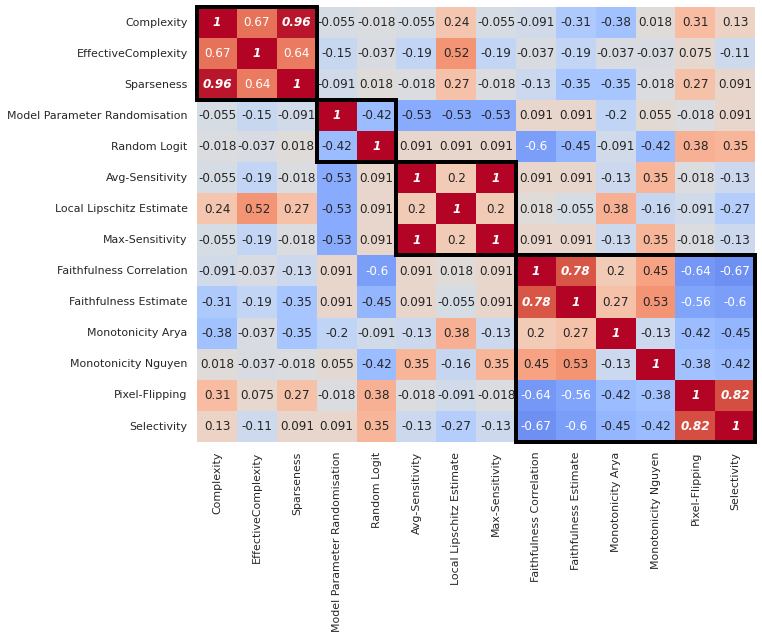

RESULTS
Kendall's W: 0.05398886827458256
Kendall's Tau:
Complexity / EffectiveComplexity : 0.6731618328060892 (0.0045931232121266714)
Complexity / Sparseness : 0.9636363636363636 (5.511463844797178e-07)
Complexity / Model Parameter Randomisation : -0.05454545454545454 (0.8792698312489979)
Complexity / Random Logit : -0.018181818181818184 (1.0)
Complexity / Avg-Sensitivity : -0.05454545454545454 (0.8792698312489979)
Complexity / Local Lipschitz Estimate : 0.23636363636363636 (0.3587114698573032)
Complexity / Max-Sensitivity : -0.05454545454545454 (0.8792698312489979)
Complexity / Faithfulness Correlation with baseline_black : -0.0909090909090909 (0.7611503928170594)
Complexity / Faithfulness Estimate with baseline_black : -0.3090909090909091 (0.21834651074234407)
Complexity / Monotonicity Arya with baseline_black : -0.38181818181818183 (0.12097096961680295)
Complexity / Monotonicity Nguyen with baseline_black : 0.018181818181818184 (1.0)
Complexity / Pixel-Flipping with baseline_black :

In [141]:
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_default_baselines_with_subgroups'
plot_corr_matrix_figure(dico_ranks, selected_metrics, labels, labels, filename, fig_size=(10,8), rotate_x=False, subgroups=(3,2,3,6))

## All metrics with all baselines

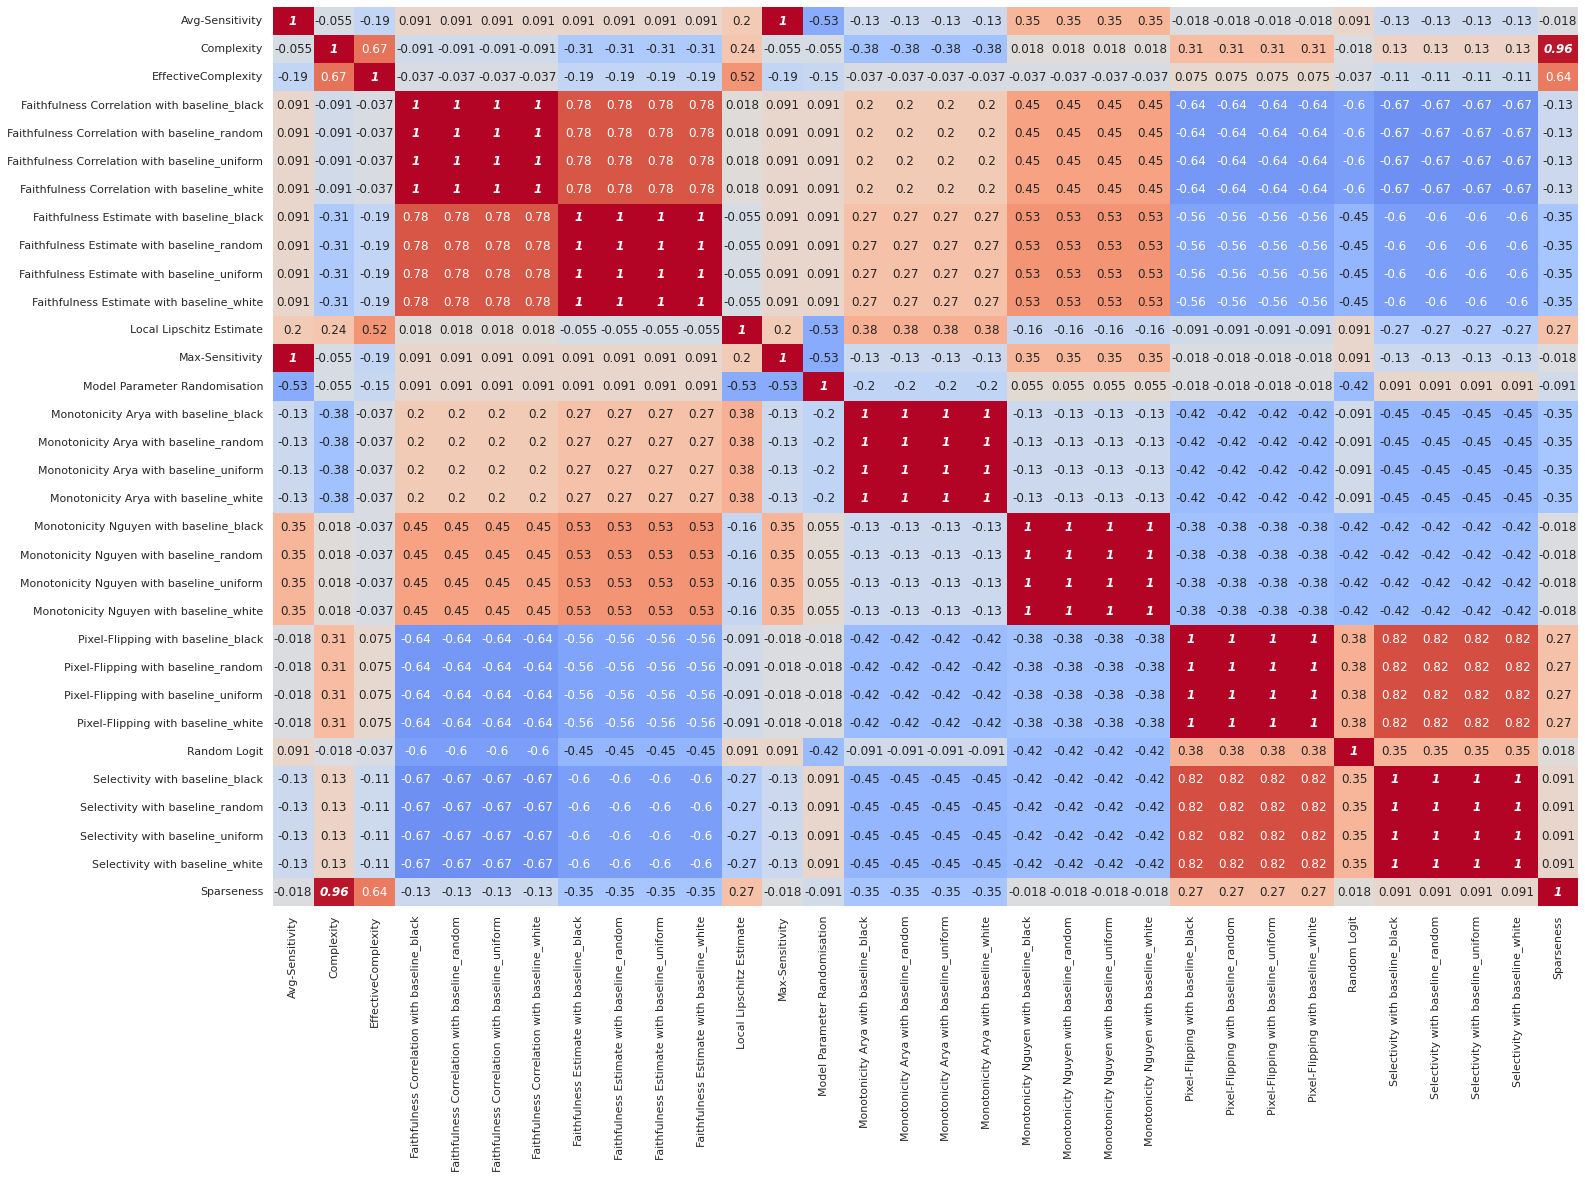

RESULTS
Kendall's W: 0.03307883522727273
Kendall's Tau:
Avg-Sensitivity / Complexity : -0.05454545454545454 (0.8792698312489979)
Avg-Sensitivity / EffectiveComplexity : -0.18698939800169143 (0.43110871510293713)
Avg-Sensitivity / Faithfulness Correlation with baseline_black : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Correlation with baseline_random : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Correlation with baseline_uniform : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Correlation with baseline_white : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Estimate with baseline_black : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Estimate with baseline_random : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Estimate with baseline_uniform : 0.0909090909090909 (0.7611503928170594)
Avg-Sensitivity / Faithfulness Estimate with baseline_wh

In [142]:
selected_metrics = sorted(dico_ranks.keys())
filename = 'final_corr_matrix_avg_aggreg_holm_corr_all_metrics_all_baselines'
plot_corr_matrix_figure(dico_ranks, selected_metrics, selected_metrics, selected_metrics, filename, fig_size=(23.4,16.54), rotate_x=False)